## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.

For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  The goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.



<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [57]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

`1.` Reading the `ab_data.csv` data. Storing it in `df`.

In [58]:
df=pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


The number of unique users in the dataset:

In [60]:
df.user_id.nunique()

290584

The proportion of users converted:

In [61]:
df.converted.mean()

0.11965919355605512

The number of times the `new_page` and `treatment` don't line up.

In [62]:
df.query('group=="control" and landing_page=="new_page" or group=="treatment" and landing_page=="old_page"').shape

(3893, 5)

Do any of the rows have missing values?

In [63]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page. 


In [64]:
a=df.query('group=="control" and landing_page=="new_page" or group=="treatment" and landing_page=="old_page"').index
np.array(a)

df2=df.drop(index=a,axis=0)

In [65]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

How many unique **user_id**s are in **df2**?

In [66]:
df2.user_id.nunique()

290584

Finding for any duplicacy in the data:

In [67]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Removing the duplicated record

In [68]:
df.drop(index=2893,axis=0,inplace=True)



What is the probability of an individual converting regardless of the page they receive?

In [69]:
df2.converted.mean()

0.11959667567149027

Given that an individual was in the `control` group, what is the probability they converted?

In [70]:
cobs=df2.query("group=='control'")['converted'].mean()
cobs

0.1203863045004612

Given that an individual was in the `treatment` group, what is the probability they converted?

In [71]:
tobs=df2.query("group=='treatment'")['converted'].mean()
tobs

0.11880724790277405

In [72]:
#their difference(cobs-tobs)
cobs-tobs

0.0015790565976871451

What is the probability that an individual received the new page?

In [73]:
(df2.landing_page=='new_page').mean()

0.5000636646764286

Considering the results from the questions above we can say that :

>From this result we can't analyse that the New Ecommerce page get more conversions because we get very less differece between the new page and the old page. Due to this we have to do next level of examination.

<a id='ab_test'></a>
### Part II - A/B Test

`1.` Considering the fact the decision to be made is just based on all the data provided. Assuming that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, the null and alternative hypothsis can be formed as :

> ### H0 : P𝑛𝑒𝑤 - P𝑜𝑙𝑑 <=0
> ### H1 : P𝑛𝑒𝑤 - P𝑜𝑙𝑑 > 0

**$p_{old}$** and **$p_{new}$**, are the converted rates for the old and new pages respectively

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Using a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Performing the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>


What is the **convert rate** for $p_{new}$ under the null? 

In [74]:
pnew=df2.converted.mean()
pnew

0.11959667567149027

What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [75]:
pold=df2.converted.mean()
pold

0.11959667567149027

What is $n_{new}$?

In [76]:
nnew=df2[df2.landing_page=='new_page'].shape[0]
nnew

145311

What is $n_{old}$?

In [77]:
nold=df2[df2.landing_page=='old_page'].shape[0]
nold

145274

Simulating $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Storing these $n_{new}$ 1's and 0's in **new_page_converted**.

In [78]:
new_page_converted=np.random.choice([1,0],size=nnew,p=[pnew,1-pnew])

Simulating $n_{old}$ transactions with a convert rate of $p_{old}$ under the null. Storing these $n_{old}$ 1's and 0's in **old_page_converted**.

In [79]:
old_page_converted=np.random.choice([1,0],size=nold,p=[pold,1-pold])

Finding $p_{new}$ - $p_{old}$ for our simulated values

In [80]:
new_page_converted.mean()-old_page_converted.mean()

-0.00030567103007952956

Simulating 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts above.  Storing all 10,000 values in a numpy array

In [81]:
diff=[]
for i in range(10000):
    nc=np.random.choice([1,0],size=nnew,p=[(pnew),(1-pnew)])
    oc=np.random.choice([1,0],size=nold,p=[(pold),(1-pold)])
    d=nc.mean()-oc.mean()
    diff.append(d)

Plotting a histogram of the **diffs**.

In [82]:
np.array(diff)

array([ 2.65766550e-04, -6.43045321e-04,  4.54510697e-05, ...,
       -6.91209098e-04,  1.24969622e-03, -7.84632423e-05])

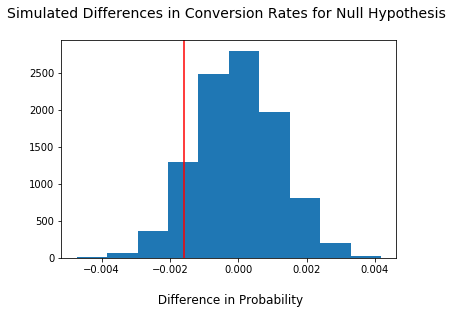

In [83]:
plt.hist(diff)
plt.title("Simulated Differences in Conversion Rates for Null Hypothesis \n", fontsize=14)
plt.xlabel("\n Difference in Probability", fontsize=12)
plt.axvline(tobs-cobs, color='r');

In [84]:
ob=tobs-cobs

What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [85]:
diff=pd.Series(diff)

In [86]:
(diff>ob).mean()

0.9023

>0.9023 is pvalue. P Value is the probability that the null hypothesis is true. As we see very large P Value which fail to rejects the null hypothesis. This means that Users are still on the old page and new page conversion rate is very small.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, we will see that the result we acheived in the previous A/B test can also be acheived by performing logistic regression.<br><br>

The goal is to use **statsmodels** to fit the logistic regression model to see if there is a significant difference in conversion based on which page a customer receives. 
However, we first need to create a column for the intercept, and create a dummy variable column for which page each user received. 
Adding an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [87]:
df2['intercept'] = 1
df2[['control','treatment']] = pd.get_dummies(df2['group'])

Using **statsmodels** to import the regression model.  Instantiating the model, and fitting the model using the two columns  created in part to predict whether or not an individual converts.

In [88]:
import statsmodels.api as sm

logit = sm.Logit(df2['converted'],df2[['intercept' ,'treatment']])
results = logit.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


Summary of the model below:

In [89]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290583
Method:                           MLE   Df Model:                            1
Date:                Fri, 17 Jul 2020   Pseudo R-squ.:               8.085e-06
Time:                        01:39:30   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1897
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
treatment     -0.0150      0.011     -1.312      0.190      -0.037       0.007
==============================================================================
"""

>Here also we're getting the Pvalue of around 0.190 which is greater than our type 1 error rate.So we fail to reject the null hypothesis.